In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import required libraries

In [2]:
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image, ImageChops
import cv2
from google.colab.patches import cv2_imshow

## 2. Import the CNN model and define the classes

In [3]:
model = load_model('/content/drive/MyDrive/Machine Learning Assignment/Demo Hand-in/CNN98_model.h5')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

## 3. Define functions for image segmentation

The trim() function takes an image and removes the blank space around the edges

In [4]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

The auto_canny() function returns a canny edge image, using the optimal lower and upper thresholds

In [5]:
def auto_canny(image, sigma=0.33):
	v = np.median(image)
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	return edged

The locate() function identifies a number of regions within the image, but only highlights the segment closest to the centre of the image

In [6]:
def locate(img_path):
  raw_img = Image.open(img_path)
  img = np.array(trim(raw_img))
  img_scaled = cv2.resize(img, (512, 512))
  img_shifted = cv2.pyrMeanShiftFiltering(img_scaled, 21, 51)
  img_gray = cv2.cvtColor(img_shifted, cv2.COLOR_BGR2GRAY, 0.7)
  (T, thresh) = cv2.threshold(img_gray, 95, 255, cv2.THRESH_BINARY)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
  closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
  closed = cv2.erode(closed, None, iterations = 7)
  closed = cv2.dilate(closed, None, iterations = 9)
  canny = auto_canny(closed)
  image_center = np.array((int(img_scaled.shape[0] / 2), int(img_scaled.shape[1] / 2)))
  (cnts, j) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts_centers = []
  for c in cnts:
    cnts_centers.append(tuple(c.mean(axis=0)))
  cnts_centers = np.array(cnts_centers)
  distances = np.linalg.norm(cnts_centers - image_center, axis=2)
  min_index = np.argmin(distances)
  cv2.drawContours(img_scaled, [cnts[min_index]], -1, (0, 0, 255), 2)
  cv2_imshow(img_scaled)

## 4. Define class prediction algorithm

The predict() function takes a path to an image and returns the predicted class name

In [7]:
def predict(img_path):
  test_img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
  img = img_to_array(test_img)/255.0
  y_pred = model.predict(img[None, ...])
  classes = np.argmax(y_pred, axis=1)
  return np.array(categories)[classes][0], max(max(y_pred))

## 5. Define method to perform full diagnosis and image segmentation

The diagnose() function takes an image path and then calls the predict() and locate() methods. The locate method outputs the segmented image and then the predicted class is also outputted, along with the surity

In [8]:
def diagnose(img_path):
  diagnosis, surety = predict(img_path)
  print('Diagnosis: {}\nSurety: {}%'.format(diagnosis, surety*100))
  locate(img_path)
  print('\n')

# Demo

Diagnosis: glioma
Surety: 99.9944806098938%


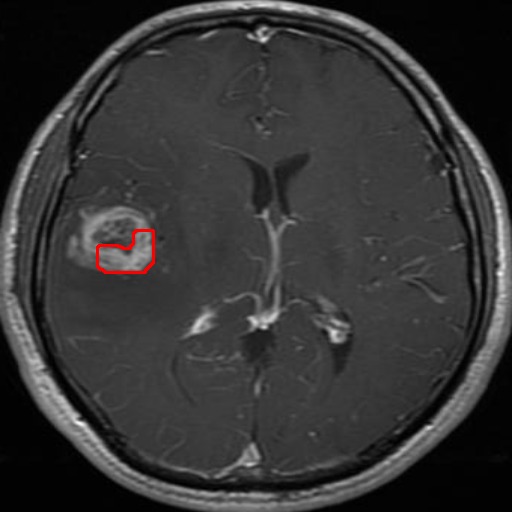



Diagnosis: meningioma
Surety: 99.8799204826355%


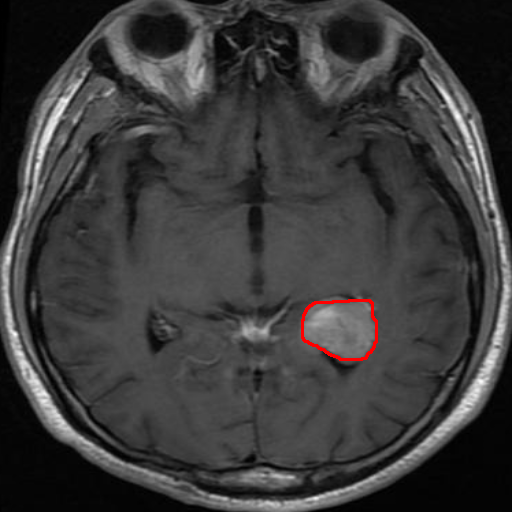



Diagnosis: pituitary
Surety: 100.0%


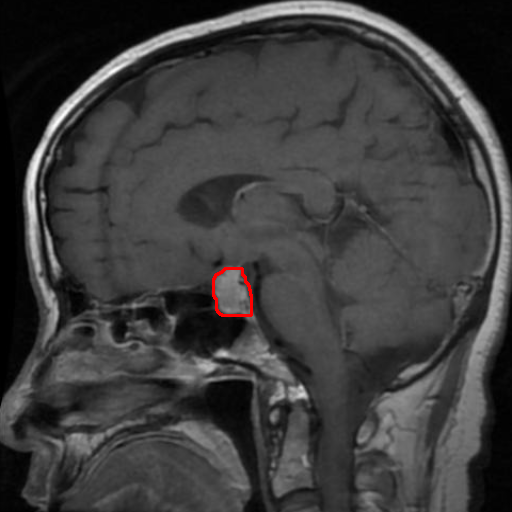

In [9]:
diagnose('/content/drive/MyDrive/Machine Learning Assignment/Dataset/Training/glioma/Tr-gl_0051.jpg')
diagnose('/content/drive/MyDrive/Machine Learning Assignment/Dataset/Training/meningioma/Tr-meTr_0001.jpg')
diagnose('/content/drive/MyDrive/Machine Learning Assignment/Dataset/Training/pituitary/Tr-pi_0048.jpg')